# Volume estimation from Input Image
Using the trained monocular depth estimation network and the known camera intrinsic parameters, we will generate a point cloud from the input image.

In [1]:
import numpy as np
import pandas as pd
import cv2
import json
import keras.backend as K
from keras.preprocessing.image import load_img, img_to_array
from keras.models import model_from_json
from pyntcloud import PyntCloud
import matplotlib.pyplot as plt
from inference.custom_modules import *
from inference.project import *
from inference.point_cloud_utils import *

# Load model architecture and weights
objs = {'ProjectionLayer': ProjectionLayer, 
        'ReflectionPadding2D': ReflectionPadding2D,
        'InverseDepthNormalization': InverseDepthNormalization,
        'AugmentationLayer': AugmentationLayer}
with open('../../results/lower_res/monovideo.json', 'r') as read_file:
    model_architecture_json = json.load(read_file)
    test_model = model_from_json(model_architecture_json,
                                      custom_objects=objs)
test_model.load_weights('../../results/lower_res/monovideo_weights_final.h5')
img_shape = test_model.inputs[0].shape[1:]

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


W0612 16:02:41.828650 139929193244480 deprecation.py:323] From /home/alex/virtualenvs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use the `axis` argument instead


W0612 16:02:47.409729 139929193244480 deprecation.py:506] From /home/alex/Projects/food_volume_estimation/tests/point_cloud/inference/project.py:205: calling squeeze (from tensorflow.python.ops.array_ops) with squeeze_dims is deprecated and will be removed in a future version.
Instructions for updating:
Use the `axis` argument instead


Instructions for updating:
Use tf.cast instead.


W0612 16:02:47.513333 139929193244480 deprecation.py:323] From /home/alex/Projects/food_volume_estimation/tests/point_cloud/inference/project.py:243: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


<IPython.core.display.Javascript object>


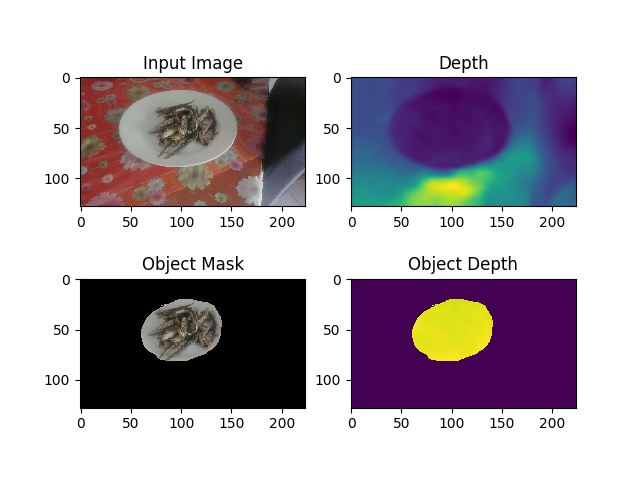

In [22]:
# Inputs-predictions
input_img = cv2.imread('inference/test_imgs/test_4.jpg', cv2.IMREAD_COLOR)
input_img = cv2.resize(input_img, (img_shape[1], img_shape[0]))
input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB) / 255
object_mask = cv2.imread('inference/test_imgs/test_4_mask.jpg', cv2.IMREAD_GRAYSCALE)
object_mask = (cv2.resize(object_mask, (img_shape[1], img_shape[0])) / 255) > 0.5
plate_mask = cv2.imread('inference/test_imgs/test_4_plate.jpg', cv2.IMREAD_GRAYSCALE)
plate_mask = (cv2.resize(plate_mask, (img_shape[1], img_shape[0])) / 255) > 0.5
test_data = [np.reshape(input_img, (1,)+input_img.shape),
             np.reshape(input_img, (1,)+input_img.shape),
             np.reshape(input_img, (1,)+input_img.shape)]
DEPTH_RESCALING = 0.5 # Depth map needs to be rescaled/calibrated
depth = test_model.predict(test_data)[19][0,:,:,0] * DEPTH_RESCALING
# Create object image/depth map
object_colors = np.tile(np.expand_dims(object_mask, axis=-1), (1,1,3)) * input_img
object_depth = object_mask * depth
plate_colors = np.tile(np.expand_dims(plate_mask, axis=-1), (1,1,3)) * input_img
plate_depth = plate_mask * depth

%matplotlib notebook
#pretty_plotting([input_img, depth, object_colors, object_depth, plate_colors, plate_depth],
#                (3,2), ['Input Image', 'Depth', 'Object Mask', 'Object Depth', 'Plate Mask', 'Plate Depth'])
pretty_plotting([input_img, depth, object_colors, object_depth],
                (2,2), ['Input Image', 'Depth', 'Object Mask', 'Object Depth'])
plt.show()

In [11]:
# Intrinsics (EPIC dataset)
#x_scaling = int(img_shape[1]) / 1920
#y_scaling = int(img_shape[0]) / 1080
#intrinsics = np.array([[1564.51*x_scaling, 0, 960*x_scaling],
#                       [0, 1564.51*y_scaling, 540*y_scaling],
#                       [0,0 ,1]], dtype=np.float32)
#intrinsics_inv = np.linalg.inv(intrinsics)

# Intrinsics (WS dataset)
#x_scaling = int(img_shape[1]) / 640
#y_scaling = int(img_shape[0]) / 480
#intrinsics = np.array([[570.3*x_scaling, 0, 320*x_scaling], [0, 570.3*y_scaling, 240*y_scaling], [0, 0, 1]])
#intrinsics_inv = np.linalg.inv(intrinsics)

# Intrinsics (Tests - LG G6)
x_scaling = int(img_shape[1]) / 1440
y_scaling = int(img_shape[0]) / 810
intrinsics = np.array([[1009*x_scaling, 0, 1440*x_scaling/2], [0, 1009*y_scaling, 810*y_scaling/2], [0, 0, 1]])
intrinsics_inv = np.linalg.inv(intrinsics)


# Depth map to point cloud
depth_tensor = K.variable(np.expand_dims(depth, 0))
intrinsics_inv_tensor = K.variable(np.expand_dims(intrinsics_inv, 0))
xyz_points = K.eval(get_cloud(depth_tensor, intrinsics_inv_tensor))
xyz_points_flat = np.reshape(xyz_points, (xyz_points.shape[1] * xyz_points.shape[2], 3))
# Get object and plate points by masking and ignoring with depth == 0
object_filter = np.reshape(object_depth, (object_depth.shape[0] * object_depth.shape[1])) > 0
plate_filter = np.reshape(plate_depth, (plate_depth.shape[0] * plate_depth.shape[1])) > 0
object_points = xyz_points_flat[object_filter, :]
plate_points = xyz_points_flat[plate_filter, :]

# Create point clouds (for plotting purposes)
colors_flat = np.reshape(input_img, (input_img.shape[0] * input_img.shape[1], 3))
object_colors_flat = colors_flat[object_filter, :] * 255
plate_colors_flat = colors_flat[plate_filter, :] * 255
object_points_df = pd.DataFrame(np.concatenate((object_points, object_colors_flat), axis=-1),
                                columns=['x','y','z','red','green','blue'])
plate_points_df = pd.DataFrame(np.concatenate((plate_points, plate_colors_flat), axis=-1),
                               columns=['x','y','z','red','green','blue'])
object_pc = PyntCloud(object_points_df)
plate_pc = PyntCloud(plate_points_df)

scene = object_pc.plot(initial_point_size=0.001, return_scene=True)
plate_pc.plot(initial_point_size=0.001, scene=scene)

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.02961868132096455, 0.007920861300654544, …

In [12]:
plane_params = ransac_plane_estimation(plate_points, k=10)
print('Estimated plane parameters (w0,w1,w2,w3):', plane_params)

# Create estimated plane point cloud
all_points = np.concatenate((object_points, plate_points), axis=0)
plane_z = np.apply_along_axis(lambda x: ((plane_params[0] + plane_params[1] * x[0]
                                          + plane_params[2] * x[1]) * (-1) / plane_params[3]),
                              axis=1, arr=all_points[:,:2])
plane_points = np.concatenate((all_points[:,:2], np.expand_dims(plane_z, axis=-1)), axis=-1)
# Plot object point cloud and plane
plane_points_df = pd.DataFrame(plane_points, columns=['x','y','z'])
plane_pc = PyntCloud(plane_points_df)

scene = object_pc.plot(initial_point_size=0.001, return_scene=True)
plate_pc.plot(initial_point_size=0.001, scene=scene)
plane_pc.plot(initial_point_size=0.005, use_as_color='z', cmap='cool', scene=scene)

Estimated plane parameters (w0,w1,w2,w3): [0.4496723711490631, -0.07077299058437347, 0.6276800036430359, -1]


/home/alex/virtualenvs/tensorflow3/lib/python3.6/site-packages/pythreejs/traits.py:177: UserWarning: 64-bit data types not supported for WebGL data, casting to 32-bit.
  warnings.warn('64-bit data types not supported for WebGL '


Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.02961868132096455, 0.007920861300654544, …

Total Volume: 1.580294303683679 L


Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.04409862337250017, 0.05324542405198263, 0…

<IPython.core.display.Javascript object>


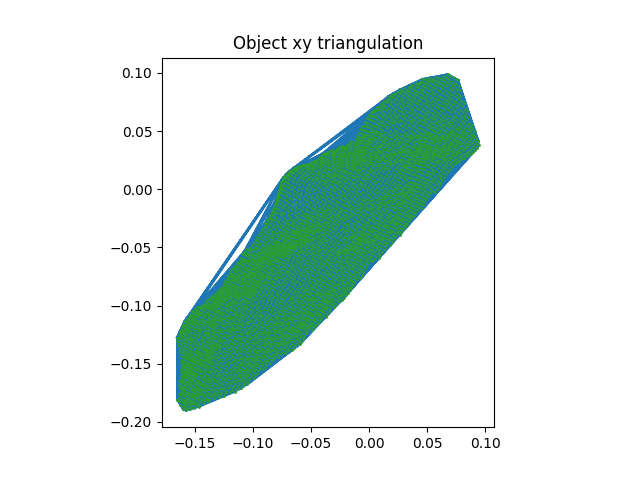

In [9]:
# Transform object and plane points
translation, rotation_matrix = align_plane_with_axis(plane_params, np.array([0,0,1]))
object_points_transformed = np.dot(object_points + translation, rotation_matrix.T)
plane_points_transformed = np.dot(plane_points + translation, rotation_matrix.T)
# Calculate volume
total_volume, simplices = estimate_volume(object_points_transformed)
print('Total Volume:', total_volume * 1000, 'L')

# Plot point clouds of transformed object and plane
object_points_transformed_df = pd.DataFrame(np.concatenate((object_points_transformed, object_colors_flat), axis=-1),
                                            columns=['x','y','z','red','green','blue'])
plane_points_transformed_df = pd.DataFrame(plane_points_transformed, columns=['x','y','z'])
plane_transformed_pc = PyntCloud(plane_points_transformed_df)
object_transformed_pc = PyntCloud(object_points_transformed_df)

scene = object_transformed_pc.plot(initial_point_size=0.001, return_scene=True)
plane_transformed_pc.plot(initial_point_size=0.005, use_as_color='x', cmap='cool', scene=scene)

# Plot xy plane triangulation
%matplotlib notebook
plt.figure()
plt.triplot(object_points_transformed[:,0], object_points_transformed[:,1], simplices)
plt.plot(object_points_transformed[:,0], object_points_transformed[:,1], 'o', markersize=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Object xy triangulation')
plt.show()